# Model building

In [296]:
#Credits to:
#https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5

In [297]:
# Importing key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from timeit import default_timer as timer
plt.style.use("bmh")

In [298]:
start = timer()

## Dataset preprocessing

In [299]:
dataset = pd.read_csv("Data/Processed/dataset.csv", index_col="Unnamed: 0", parse_dates=True)
tomorrow = pd.read_csv("Data/Processed/tomorrow.csv", index_col="Unnamed: 0", parse_dates=True)

In [300]:
dataset.tail()

,xtb,wig,spx,gld,oil,usd,vix
2020-10-12,15.3,48938.01,3534.22,1928.9,39.43,0.84643,25.070000
2020-10-13,16.1,48464.15,3511.93,1894.6,40.20,0.85142,26.070000
2020-10-14,16.3,48596.45,3488.67,1907.3,41.04,0.85117,26.400000
2020-10-15,16.1,47482.00,3483.34,1908.9,40.96,0.85394,26.969999
2020-10-16,17.8,48210.12,3483.81,1902.8,40.77,0.85341,27.410000


In [301]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1068 entries, 2016-05-06 to 2020-10-16
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xtb     1068 non-null   float64
 1   wig     1068 non-null   float64
 2   spx     1068 non-null   float64
 3   gld     1068 non-null   float64
 4   oil     1068 non-null   float64
 5   usd     1068 non-null   float64
 6   vix     1068 non-null   float64
dtypes: float64(7)
memory usage: 66.8 KB


In [302]:
# Chosing features and labels
labels = dataset["xtb"].values
features = dataset.drop("xtb", axis=1).values

In [303]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [304]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    labels, 
                                                    test_size=0.4, 
                                                    random_state=42)

## Model selection and metrics

In [305]:
lr = LinearRegression()
rge = Ridge()
hr = HuberRegressor()
dtr = DecisionTreeRegressor()
rfr = RandomForestRegressor()

In [306]:
results = pd.DataFrame(columns=["R2","RMSE"], index=["lr", "rge", "hr", "dtr", "rfr"])

for regressor, name in zip([lr, rge, hr, dtr, rfr], ["lr", "rge", "hr", "dtr", "rfr"]):
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    results.loc[name]["R2"] = r2_score(y_test, predictions)
    results.loc[name]["RMSE"] = np.sqrt(mean_squared_error(y_test, predictions))

results = results.sort_values("R2", ascending=False)
print(results.to_markdown())

|     |       R2 |     RMSE |
|:----|---------:|---------:|
| rfr | 0.962335 | 0.787382 |
| dtr | 0.932874 | 1.05114  |
| rge | 0.632129 | 2.46072  |
| lr  | 0.631686 | 2.46221  |
| hr  | 0.600565 | 2.56412  |


In [307]:
# Best estimator parameters
rfr.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

## Cross Validation

In [308]:
cvscore = cross_val_score(rfr, X_train, y_train, cv=9)
print(f"R2: {cvscore.mean().round(4)}")

R2: 0.9621


## Feature importance

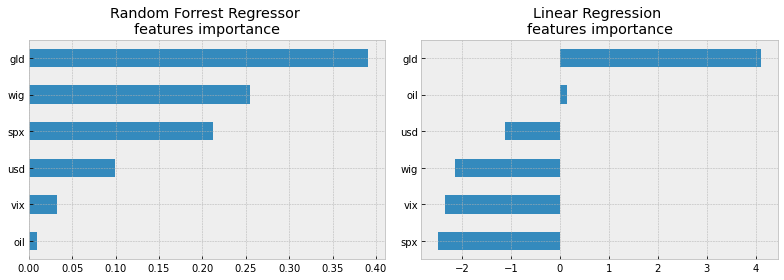

In [309]:
feature_imp_rfr = pd.Series(index=dataset.drop("xtb", axis=1).columns, 
                               data=rfr.feature_importances_ ,name="Coef").sort_values()

feature_imp_lr = pd.Series(index=dataset.drop("xtb", axis=1).columns, 
                               data=lr.coef_).sort_values()

# Features importance
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,4))

feature_imp_rfr.plot(kind="barh", ax=ax[0], subplots=True)
ax[0].set(title="Random Forrest Regressor \nfeatures importance")
feature_imp_lr.plot(kind="barh", ax=ax[1], subplots=True)
ax[1].set(title="Linear Regression \nfeatures importance")

plt.tight_layout()
plt.show()

## Searching for better parameters

In [310]:
# Grid search
params = {"n_estimators":[100,500], 
          "min_samples_split":[2,3], 
          "max_features":["auto", "sqrt", "log2"]}

gs = GridSearchCV(rfr, params, cv=9, n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best score:", gs.best_score_)

Best params: {'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9691306078185836


## Model with the highest R2 score results

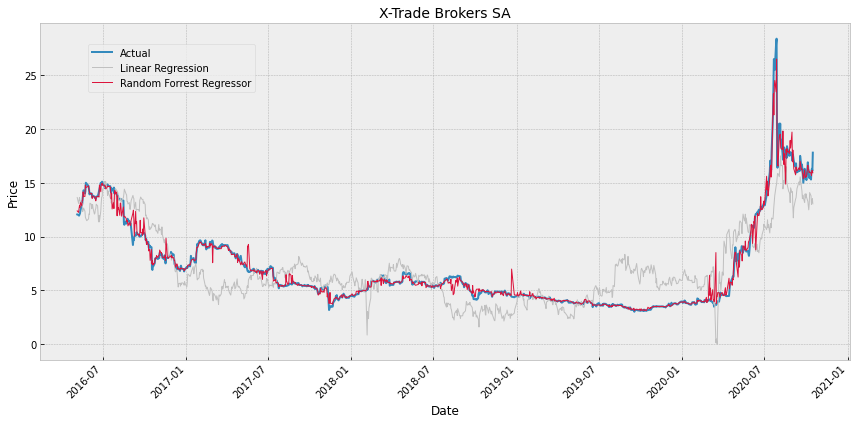

In [311]:
# Plotting model predictions

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, pd.Series(lr.predict(features)), linewidth=1, c="silver")
ax.plot(dataset.index, pd.Series(rfr.predict(features)), linewidth=1, c="crimson")

fig.legend(["Actual", "Linear Regression", "Random Forrest Regressor"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

## Next day price prediction

In [312]:
tomorrow.T

,wig,spx,gld,oil,usd,vix
2020-10-15,47482.0,3483.34,1908.9,40.96,0.85394,26.969999


In [313]:
tomorrow = scaler.transform(tomorrow.T)
next_price = rfr.predict(tomorrow.reshape(1,-1))
print("RFR Prediction for tommorow:","\t", next_price)

RFR Prediction for tommorow: 	 [16.0905]


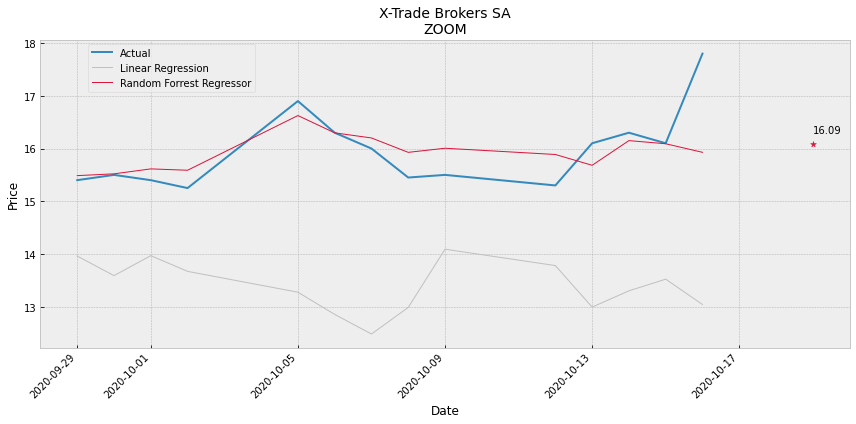

In [314]:
# Plotting model predictions zoom

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA\nZOOM", fontsize=14)

ax.plot(dataset.index[-14:], dataset.xtb[-14:], linewidth=2)
ax.plot(dataset.index[-14:], pd.Series(lr.predict(features))[-14:], linewidth=1, c="silver")
ax.plot(dataset.index[-14:], pd.Series(rfr.predict(features))[-14:], linewidth=1, c="crimson")
ax.scatter(x="2020-10-19", y=next_price,  marker="*", c="crimson")
ax.annotate(text=next_price[0].round(2), xy=("2020-10-19", 16.3))

fig.legend(["Actual", "Linear Regression", "Random Forrest Regressor"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

In [315]:
stop = timer()

In [321]:
print(round(stop-start, 2),"sec")

100.93 sec
